In [6]:
import qiskit.quantum_info as qi
import qimax.constant as constant
from qoop.core.random_circuit import generate_with_pool
from qoop.core.gradient import grad_loss
import qimax.splitter, qimax.utilities
%load_ext autoreload
%autoreload 2
num_qubits = 5
qc = generate_with_pool(num_qubits, 5)
qc = qc.assign_parameters([1] * qc.num_parameters)
qc_qasm = (qc.qasm())
print(qc_qasm)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
ry(1.0) q[0];
rx(1.0) q[1];
crz(1.0) q[3],q[4];
h q[2];
crx(1.0) q[0],q[2];
rx(1.0) q[3];
crz(1.0) q[4],q[1];
ry(1.0) q[1];
cx q[4],q[3];
ry(1.0) q[2];
h q[0];
ry(1.0) q[2];
h q[4];
h q[3];
h q[0];
ry(1.0) q[1];
rx(1.0) q[0];
cry(1.0) q[1],q[2];
rz(1.0) q[3];
rz(1.0) q[4];



In [9]:
import qiskit
import numpy as np, re
import qimax.splitter
qasm_gates = qimax.splitter.qasm_to_qasmgates(qc_qasm)
qcs = qimax.splitter.qasmgates_to_qcs2(qasm_gates)
for qcss in qcs:
    print(qcss)

5
[('RY', 1.0, [0])]
[('RX', 1.0, [1])]
[('CRZ', 1.0, [3, 4]), ('H', -999, [2])]
[('CRX', 1.0, [0, 2])]
[('RX', 1.0, [3])]
[('CRZ', 1.0, [4, 1])]
[('RY', 1.0, [1]), ('CX', -999, [4, 3])]
[('RY', 1.0, [2]), ('H', -999, [0])]
[('RY', 1.0, [2]), ('H', -999, [4]), ('H', -999, [3]), ('H', -999, [0])]
[('RY', 1.0, [1])]
[('RX', 1.0, [0])]
[('CRY', 1.0, [1, 2])]
[('RZ', 1.0, [3])]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


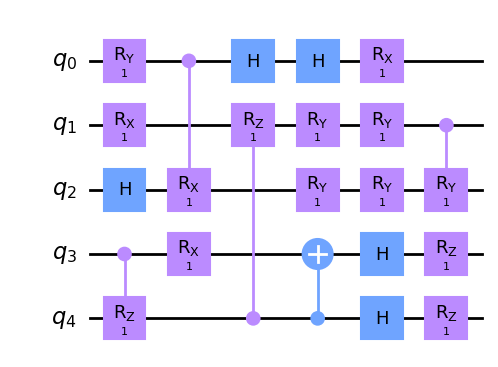

In [10]:
qc.draw('mpl')

In [33]:
import qiskit, numpy as np







